In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
from collections import defaultdict
from random import sample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from surprise import SVD, SVDpp, Dataset, Reader, accuracy


## Chuẩn bị dữ liệu

In [ ]:
# Read file csv
ratings = pd.read_csv('../data/ratings.csv')
movies = pd.read_csv('../data/movies.csv')
tags = pd.read_csv('../data/tags.csv')

# Nối bảng 'ratings' với 'movies' để lấy tiêu đề phim
df = pd.merge(ratings, movies, on='movieId')

In [ ]:
user_encoder  = LabelEncoder()
movie_encoder = LabelEncoder()

df['user_idx']  = user_encoder.fit_transform(df['userId'])
df['movie_idx'] = movie_encoder.fit_transform(df['movieId'])

n_users  = df["user_idx"].nunique()
n_items  = df["movie_idx"].nunique()
print(f"Dataset: {len(df):,} ratings | {n_users:,} users | {n_items:,} movies")


# Hàm chia dữ liệu thành tập train, test, val, đảm bảo mỗi user đều có mặt ở cả hai tập
def train_val_test_plit(
        data_frame,                 # Bộ dữ liệu cần chia train/set/val được lưu dưới dạng DataFrame
        test_size=0.1,              # Tỉ lệ tập test so với cả bộ
        val_size=0.1,               # Tỉ lệ tập val so với cả bộ
        stratify_col='user_idx',    # Tên cột mà đảm bảo mỗi giá trị phân biệt đều có mặt ở cả hai tập
        random_state=42             # Tùy chọn ngẫu nhiên
    ):
    train_val_df, test_df = train_test_split(
        data_frame, 
        test_size=test_size, 
        random_state=random_state,
        stratify=data_frame[stratify_col]  
    )

    train_df, val_df = train_test_split(
        train_val_df, 
        test_size=val_size, 
        random_state=random_state,
        stratify=train_val_df[stratify_col]
    ) 
    return train_df, val_df, test_df

# train_df, val_df, test_df = train_val_test_plit(df[["user_idx", "movie_idx", "rating"]])
train_df, val_df, test_df = train_val_test_plit(df)


Dataset: 25,000,095 ratings | 162,541 users | 59,047 movies


## **Thuật toán FunkSVD**

### Cài đặt thuật toán

- **Mục tiêu:** Xấp xỉ ma trận đánh giá thưa $$ R \in \mathbb{R}^{n_{\text{users}} \times n_{\text{items}}} $$ bằng tích của hai ma trận yếu tố ẩn  
  $$ P \in \mathbb{R}^{n_{\text{users}} \times k}, \quad Q \in \mathbb{R}^{n_{\text{items}} \times k}, \quad R \approx PQ^T $$

- **Dự đoán:** Điểm đánh giá dự đoán cho người dùng $ u $ và phim $ i $:

  $$
  \hat{r}_{ui} = \mu + b_u + b_i + P_u \cdot Q_i
  $$

  Trong đó:

  - $\mu $: Trung bình toàn bộ đánh giá (global bias).
  - $ b_u $: Bias của người dùng $u$ (xu hướng đánh giá cao/thấp).
  - $ b_i $: Bias của phim $ i $ (xu hướng được đánh giá cao/thấp).
  - $ P_u \cdot Q_i $: Tích vô hướng của vector yếu tố ẩn (kích thước $ k $).

- **Hàm mất mát:** Tối thiểu hóa sai số bình phương với điều chuẩn riêng cho bias và yếu tố ẩn:

  $
  L = \sum_{(u,i) \in \text{known ratings}} (r_{ui} - \hat{r}_{ui})^2 + \lambda_{bu,bi} \left( \sum_u b_u^2 + \sum_i b_i^2 \right) + \lambda_{pq} \left( \sum_u \| P_u \|^2 + \sum_i \| Q_i \|^2 \right)
  $

  Trong đó:

  - $ (r_{ui} - \hat{r}_{ui})^2 $: Sai số bình phương.
  - $ \lambda_{bu,bi} $: Hệ số điều chuẩn cho bias (`reg_bu_bi`).
  - $ \lambda_{pq} $: Hệ số điều chuẩn cho yếu tố ẩn (`reg_pq`).
  - $ b_u^2, b_i^2, \|P_u\|^2, \|Q_i\|^2 $: Phạt các giá trị lớn để tránh overfitting.

- **Tối ưu hóa:** Sử dụng SGD để cập nhật $ \mu, b_u, b_i, P_u, Q_i $ từng mẫu dữ liệu một cách ngẫu nhiên, với learning rate giảm dần (decay).


In [ ]:
# Hàm df_to_numpy() dùng để chuyển DataFrame sang NumPy
def df_to_numpy(df_):
    arr = df_[["user_idx", "movie_idx", "rating"]].to_numpy()
    return arr[:, 0].astype(np.int32), arr[:, 1].astype(np.int32), arr[:, 2].astype(np.float32)

In [ ]:
class FunkSVD:
    def __init__(
        self,
        n_users: int,               # số người dùng
        n_items: int,               # số phim
        k: int = 50,                # yếu tố ẩn
        lr: float = 0.007,
        reg_bu_bi: float = 0.01,    # Hệ số điều chuẩn cho bias (b_u, b_i).
        reg_pq: float = 0.05,       # Hệ số điều chuẩn cho yếu tố ẩn (P, Q ).
        n_epochs: int = 35,
        seed: int = 42,
        verbose: bool = True,
    ):
        rng = np.random.default_rng(seed)
        # Ma trận yếu tố ẩn người dùng, khởi tạo ngẫu nhiên từ phân phối chuẩn, nhân 0.1 để giá trị nhỏ, kiểu float32.
        self.P  = 0.1 * rng.standard_normal((n_users, k)).astype(np.float32)
        # Ma trận yếu tố ẩn phim
        self.Q  = 0.1 * rng.standard_normal((n_items, k)).astype(np.float32)
        #---> Khởi tạo ngẫu nhiên P, Q với giá trị nhỏ tránh gradient lớn ban đầu.
        
        # Vector bias người dùng (b_u) -> khởi tạo = 0
        self.bu = np.zeros(n_users, dtype=np.float32)
        # Vector bias phim (b_i), khởi tạo = 0
        self.bi = np.zeros(n_items, dtype=np.float32)
        #  Global bias (\mu), khởi tạo = 0 
        self.mu = 0.0

        self.lr0 = self.lr = lr # Lưu tốc độ học ban đầu và hiện tại (sẽ giảm qua epoch)
        self.reg_bu_bi = reg_bu_bi
        self.reg_pq    = reg_pq
        self.n_epochs  = n_epochs
        self.verbose   = verbose
        self.train_rmse, self.val_rmse = [], []

    # ───── Train ─────
    def fit(self, train_df, val_df=None, patience: int = 3):
        u_tr, i_tr, r_tr = df_to_numpy(train_df)
        if val_df is not None:
            u_vl, i_vl, r_vl = df_to_numpy(val_df)

        self.mu = r_tr.mean()
        best_val = np.inf
        no_improve = 0

        for ep in range(1, self.n_epochs + 1):
            idx = np.random.permutation(len(r_tr))
            se = 0.0
            for u, i, r in zip(u_tr[idx], i_tr[idx], r_tr[idx]):
                pred = self.mu + self.bu[u] + self.bi[i] + self.P[u] @ self.Q[i]
                err  = r - pred
                se  += err * err

                # update bias
                self.bu[u] += self.lr * (err - self.reg_bu_bi * self.bu[u])
                self.bi[i] += self.lr * (err - self.reg_bu_bi * self.bi[i])

                # update latent factors
                pu_old = self.P[u].copy()
                self.P[u] += self.lr * (err * self.Q[i] - self.reg_pq * self.P[u])
                self.Q[i] += self.lr * (err * pu_old    - self.reg_pq * self.Q[i])

            rmse_tr = np.sqrt(se / len(r_tr))
            self.train_rmse.append(rmse_tr)

            # Validation
            if val_df is not None:
                preds = self.predict_batch(u_vl, i_vl)
                rmse_vl = np.sqrt(mean_squared_error(r_vl, preds))
                self.val_rmse.append(rmse_vl)

                if self.verbose:
                    print(f"Epoch {ep:02d}/{self.n_epochs} – Train {rmse_tr:.4f} | Val {rmse_vl:.4f}")

                # early-stopping
                if rmse_vl + 1e-4 < best_val:
                    best_val = rmse_vl
                    no_improve = 0
                    self._best_state = (self.P.copy(), self.Q.copy(), self.bu.copy(), self.bi.copy())
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        if self.verbose:
                            print(">>> Early-stopping – restore best epoch.")
                        self.P, self.Q, self.bu, self.bi = self._best_state
                        break
            else:
                if self.verbose:
                    print(f"Epoch {ep:02d}/{self.n_epochs} – Train RMSE: {rmse_tr:.4f}")

            self.lr *= 0.95

        return self

    # ───── Inference ─────
    def predict(self, u_idx: int, i_idx: int) -> float:
        est = (
            self.mu
            + self.bu[u_idx]
            + self.bi[i_idx]                
            + self.P[u_idx] @ self.Q[i_idx]
        )
        return float(np.clip(est, 0.5, 5.0))

    def predict_batch(self, users, items):
        return np.clip(
            self.mu + self.bu[users] + self.bi[items] +
            np.einsum("ij,ij->i", self.P[users], self.Q[items]),
            0.5, 5.0,
        )

    # ───── Save / Load ─────
    def save(self, file_path: str):
        """
        Lưu mô hình ra file .npz. 
        """
        dir_name = os.path.dirname(file_path)
        if dir_name and not os.path.exists(dir_name):
            os.makedirs(dir_name, exist_ok=True)

        np.savez_compressed(
            file_path,
            P=self.P, Q=self.Q,
            bu=self.bu, bi=self.bi,
            mu=self.mu,
            train_rmse=np.array(self.train_rmse),
            val_rmse=np.array(self.val_rmse),
            lr=self.lr, lr0=self.lr0,
            reg_bu_bi=self.reg_bu_bi,
            reg_pq=self.reg_pq,
        )

    def load(self, file_path: str):
        """
        Khôi phục model từ file .npz.
        """
        data = np.load(file_path)
        self.P  = data["P"];  self.Q  = data["Q"]
        self.bu = data["bu"]; self.bi = data["bi"]
        self.mu = float(data["mu"])
        self.train_rmse = list(data["train_rmse"])
        self.val_rmse   = list(data["val_rmse"])
        self.lr  = float(data["lr"]);  self.lr0 = float(data["lr0"])
        self.reg_bu_bi = float(data["reg_bu_bi"])
        self.reg_pq    = float(data["reg_pq"])
        return self

### Xây dựng model bằng hai cách

#### Cách 1. Sử dụng mô hình implement

In [ ]:
model_funksvd_custom = FunkSVD(
    n_users=n_users,
    n_items=n_items,
    k=50,
    lr=0.007,
    reg_bu_bi=0.01,
    reg_pq=0.05,
    n_epochs=35,
)
model_funksvd_custom.fit(train_df, val_df, patience=3)
model_funksvd_custom.save("checkpoints/funksvd_best.npz")   

Epoch 01/35 – Train 0.9029 | Val 0.8770
Epoch 02/35 – Train 0.8686 | Val 0.8676
Epoch 03/35 – Train 0.8608 | Val 0.8630
Epoch 04/35 – Train 0.8548 | Val 0.8576
Epoch 05/35 – Train 0.8475 | Val 0.8511
Epoch 06/35 – Train 0.8403 | Val 0.8457
Epoch 07/35 – Train 0.8347 | Val 0.8419
Epoch 08/35 – Train 0.8300 | Val 0.8385
Epoch 09/35 – Train 0.8259 | Val 0.8353
Epoch 10/35 – Train 0.8219 | Val 0.8324
Epoch 11/35 – Train 0.8181 | Val 0.8297
Epoch 12/35 – Train 0.8144 | Val 0.8270
Epoch 13/35 – Train 0.8109 | Val 0.8244
Epoch 14/35 – Train 0.8075 | Val 0.8222
Epoch 15/35 – Train 0.8043 | Val 0.8201
Epoch 16/35 – Train 0.8014 | Val 0.8181
Epoch 17/35 – Train 0.7986 | Val 0.8163
Epoch 18/35 – Train 0.7960 | Val 0.8146
Epoch 19/35 – Train 0.7936 | Val 0.8131
Epoch 20/35 – Train 0.7913 | Val 0.8117
Epoch 21/35 – Train 0.7892 | Val 0.8104
Epoch 22/35 – Train 0.7872 | Val 0.8093
Epoch 23/35 – Train 0.7854 | Val 0.8082
Epoch 24/35 – Train 0.7837 | Val 0.8072
Epoch 25/35 – Train 0.7821 | Val 0.8063


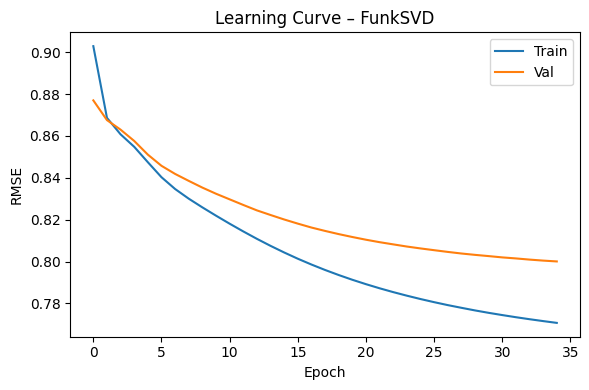

In [ ]:
# learning curve
plt.figure(figsize=(6, 4))
plt.plot(model_funksvd_custom.train_rmse, label="Train")
if model_funksvd_custom.val_rmse:
    plt.plot(model_funksvd_custom.val_rmse, label="Val")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Learning Curve – FunkSVD")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def evaluate(df_, mdl):
    u, i, r = df_to_numpy(df_)
    pr = mdl.predict_batch(u, i)
    return np.sqrt(mean_squared_error(r, pr)), mean_absolute_error(r, pr)

train_rmse, train_mae = evaluate(train_df, model_funksvd_custom)
val_rmse, val_mae = evaluate(val_df, model_funksvd_custom)
test_rmse, test_mae = evaluate(test_df, model_funksvd_custom)

print(
    f"\nRMSE | MAE\n"
    f"Train: {train_rmse:.4f} | {train_mae:.4f}\n"
    f"Val  : {val_rmse:.4f} | {val_mae:.4f}\n"
    f"Test : {test_rmse:.4f} | {test_mae:.4f}"
)


RMSE | MAE
Train: 0.7691 | 0.5855
Val  : 0.8001 | 0.6073
Test : 0.8005 | 0.6076


#### Cách 2. Sử dụng mô hình từ thư viện Surprise

In [ ]:
class SurpriseFunkSVD:
    def __init__(
        self,
        n_factors=50,
        lr_all=0.007,
        reg_all=0.02,
        n_epochs=20,
        verbose=False,
        rating_scale=(0.5, 5.0)
    ):
        self.model = SVD(n_factors=n_factors, lr_all=lr_all, reg_all=reg_all,
                         n_epochs=n_epochs, verbose=verbose)
        self.rating_scale = rating_scale

    def fit(self, train_df):
        reader = Reader(rating_scale=self.rating_scale)
        data = Dataset.load_from_df(train_df[['user_idx', 'movie_idx', 'rating']], reader)
        trainset = data.build_full_trainset()
        self.model.fit(trainset)
        return self

    def predict(self, u_idx: int, i_idx: int) -> float:
        est = self.model.predict(uid=u_idx, iid=i_idx).est
        return float(np.clip(est, *self.rating_scale))

    def predict_batch(self, users, items):
        preds = []
        for u, i in tqdm(zip(users, items), total=len(users), desc="Predicting"):
            preds.append(self.predict(u, i))
        return np.array(preds)

    def recommend_for_nan(self, df):
        df_nan = df[df["rating"].isna()].copy()
        predictions = self.predict_batch(df_nan["user_idx"].values, df_nan["movie_idx"].values)
        df_nan["predicted_rating"] = predictions
        return df_nan

    def save(self, file_path: str):
        import joblib
        joblib.dump(self.model, file_path)

    def load(self, file_path: str):
        import joblib
        self.model = joblib.load(file_path)
        return self

In [ ]:
model_funksvd = SurpriseFunkSVD(n_factors=50, n_epochs=35)
model_funksvd.fit(train_df) 

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34


In [ ]:
# Dự đoán hàng loạt
preds = model_funksvd.predict_batch(val_df["user_idx"], val_df["movie_idx"])
val_df["predicted_rating"] = preds

Predicting: 100%|██████████| 2000008/2000008 [00:28<00:00, 70853.08it/s] 


In [ ]:
def evaluate(df, model):
    u, i, r = df["user_idx"], df["movie_idx"], df["rating"]
    p = model.predict_batch(u, i)
    return np.sqrt(mean_squared_error(r, p)), mean_absolute_error(r, p)

tr_rmse, tr_mae = evaluate(train_df, model_funksvd)
vl_rmse, vl_mae = evaluate(val_df, model_funksvd)
ts_rmse, ts_mae = evaluate(test_df, model_funksvd)

print(
    f"\nRMSE  | MAE\n"
    f"Train: {tr_rmse:.4f} | {tr_mae:.4f}\n"
    f"Val  : {vl_rmse:.4f} | {vl_mae:.4f}\n"
    f"Test : {ts_rmse:.4f} | {ts_mae:.4f}"
)


Predicting: 100%|██████████| 5000019/5000019 [01:18<00:00, 64042.52it/s] 



RMSE  | MAE
Train: 0.6132 | 0.4646
Val  : 0.7863 | 0.5916
Test : 0.7862 | 0.5916


## **Thuật toán SVD++**

### Cài đặt thuật toán

#### **1. Công thức dự đoán rating và ý tưởng**

Giả sử $R_{n \times m}$ là ma trận đánh giá gồm $n$ người dùng và $m$ mặt hàng. Mỗi phần tử $r_{ui}$ là đánh giá của người dùng $u$ cho mặt hàng $i$.

Công thức dự đoán rating trong mô hình **SVD++** là:

$$
\hat{r}_{ui} = \mu + b_u + b_i + q_i^T \left(p_u + \frac{1}{\sqrt{|N(u)|}} \sum_{j \in N(u)} y_j \right)
$$

Trong đó:

- $\mu$: trung bình các rating toàn bộ hệ thống  
- $b_u$, $b_i$: độ lệch riêng của người dùng $u$ và movie $i$  
- $p_u$, $q_i$: vector tiềm ẩn đại diện cho người dùng và movie
- $y_j$: vector phản hồi ngầm của movie $j$
- $N(u)$: tập các movie mà người dùng $u$ đã đánh giá

Ý tưởng của SVD++ là kết hợp **cả thông tin explicit (rating)** và **implicit feedback (dạng hành vi như gắn tag, click, xem phim, v.v.)** để cải thiện độ chính xác khi dự đoán.


#### **2. Hàm mất mát (Loss function)**

Hàm mất mát của mô hình SVD++ được định nghĩa như sau:

$$
\sum_{r_{ui} \in R} \left[ \left(r_{ui} - \mu - b_u - b_i - q_i^T \left(p_u + \frac{1}{\sqrt{|N(u)|}} \sum_{j \in R(u)} y_j \right) \right)^2 + \lambda_1 (b_u^2 + b_i^2) + \lambda_2 ( \|p_u\|^2 + \|q_i\|^2 ) \right]
$$

Giải thích các thành phần:

- Thành phần đầu là **sai số bình phương** giữa rating thực tế và rating dự đoán.

- Các biểu thức chứa $\lambda_1$ và $\lambda_2$ là **regularization**:

  - $\lambda_1$: điều chỉnh độ lệch (bias)

  - $\lambda_2$: điều chỉnh độ lớn của vector tiềm ẩn

Regularization giúp giảm **overfitting**, nhất là khi dữ liệu đánh giá bị **thưa** (sparse). Nó hạn chế mô hình "học thuộc" toàn bộ dữ liệu train và giúp tổng quát hóa tốt hơn trên tập validation.


#### **3. Quy tắc cập nhật tham số bằng SGD**

Với mỗi mini-batch, chọn ngẫu nhiên các mẫu và cập nhật các tham số $b_u, b_i, p_u, q_i, y_j$ dựa trên sai số $e_{ui} = r_{ui} - \hat{r}_{ui}$ theo các công thức sau:

- $
b_u \leftarrow b_u + \gamma \cdot (e_{ui} - \lambda_1 \cdot b_u)
$

- $
b_i \leftarrow b_i + \gamma \cdot (e_{ui} - \lambda_1 \cdot b_i)
$

- $
q_i \leftarrow q_i + \gamma \cdot \left( e_{ui} \cdot \left( p_u + \frac{1}{\sqrt{|N(u)|}} \sum_{j \in N(u)} y_j \right) - \lambda_2 \cdot q_i \right)
$

- $
p_u \leftarrow p_u + \gamma \cdot (e_{ui} \cdot q_i - \lambda_2 \cdot p_u)
$

- $
\forall j \in N(u): \quad y_j \leftarrow y_j + \gamma \cdot \left( \frac{e_{ui}}{\sqrt{|N(u)|}} \cdot q_i - \lambda_2 \cdot y_j \right)
$

Trong đó:

- $\gamma$: learning rate  
- $\lambda_1, \lambda_2$: hệ số regularization  
- $N(u)$: tập các movie mà user $u$ đã đánh giá  

Mỗi lần cập nhật là một bước tiến nhỏ giúp mô hình tối ưu dần các tham số để giảm sai số dự đoán.


In [ ]:
class SVDPP:
    """
    Mô hình SVD++.

    ratings: list các bộ (user_idx, movie_idx, rating)
    implicit_feedback: dict {user_idx: set(movie_idx)} 
    num_users, num_items: tổng số user/item
    n_factors: số chiều của vector tiềm ẩn
    lr_all: learning rate
    reg_all: hệ số regularization mặc định
    reg1, reg2: regularization cho bias và vector
    epochs: số vòng lặp huấn luyện
    """
    def __init__(self, 
                 ratings, implicit_feedback, num_users, num_items, 
                 n_factors=20, 
                 lr_all=0.007, 
                 reg_all=0.02, 
                 reg1=None, reg2=None,
                 decay=0.95,
                 seed=42,
                 epochs=20):
        self.ratings = ratings  
        self.Nu = implicit_feedback  
        self.n_factors = n_factors
        self.lr_all = lr_all
        self.reg_all = reg_all
        self.reg1 = reg1 if reg1 is not None else reg_all
        self.reg2 = reg2 if reg2 is not None else reg_all
        self.epochs = epochs
        self.decay= decay

        self.num_users = num_users
        self.num_items = num_items

        self.bu = np.zeros(num_users, dtype=np.float32)
        self.bi = np.zeros(num_items, dtype=np.float32)

        rng = np.random.default_rng(seed)
        self.pu = 0.1 * rng.standard_normal((num_users, n_factors)).astype(np.float32)
        self.qi =  0.1 * rng.standard_normal((num_items, n_factors)).astype(np.float32)

        # yj must cover all item indices that appear in implicit feedback
        all_implicit_items = set()
        for items in implicit_feedback.values():
            all_implicit_items.update(items)
        self.yj = np.random.normal(0, 0.1, (num_items, n_factors)).astype(np.float32)  # Pre-allocate full matrix

        self.global_mean = np.float32(np.mean([r for _, _, r in ratings]))

    def predict(self, u, i, sum_yj_u=None):
        """
        Dự đoán rating của user u cho item i.
        Nếu đã tính trước sum_yj_u thì truyền vào để tăng tốc.
        """
        if sum_yj_u is None:
            implicit_items = self.Nu.get(u, set())
            sqrt_Nu = math.sqrt(len(implicit_items)) if implicit_items else 1.0
            sum_yj_u = (
                np.sum(self.yj[list(implicit_items)], axis=0) 
                / np.float32(sqrt_Nu)).astype(np.float32) if implicit_items else np.zeros(self.n_factors, dtype=np.float32
            )

        interaction = self.pu[u] + sum_yj_u
        return self.global_mean + self.bu[u] + self.bi[i] + np.dot(interaction, self.qi[i])

    def compute_sum_yj_dict(self):
        sum_yj_dict = {}
        for u in range(self.num_users):
            implicit_items = self.Nu.get(u, set())
            if implicit_items:
                sqrt_Nu = math.sqrt(len(implicit_items))
                sum_yj_dict[u] = (np.sum(self.yj[list(implicit_items)], axis=0) / np.float32(sqrt_Nu)).astype(np.float32)
            else:
                sum_yj_dict[u] = np.zeros(self.n_factors, dtype=np.float32)
        return sum_yj_dict

    def train(self, val_set=None, early_stopping=False, patience=3):
        """
        Huấn luyện mô hình bằng SGD.

        val_set: tập validation (nếu có)
        early_stopping: optional
        patience: số vòng cho phép không cải thiện trước khi dừng
        """
        best_val_rmse = float('inf')
        patience_counter = 0

        for epoch in range(self.epochs):
            random.shuffle(self.ratings)

            # Precompute sum_yj for each user
            sum_yj_dict = self.compute_sum_yj_dict()

            for u, i, r in tqdm(self.ratings, desc=f"Training Epoch {epoch+1}", leave=False):
                u = int(u)
                i = int(i)
                sum_yj_u = sum_yj_dict[u]
                pred = self.predict(u, i, sum_yj_u)
                err = np.float32(r) - pred

                # Update biases
                self.bu[u] += self.lr_all * (err - self.reg1 * self.bu[u])
                self.bi[i] += self.lr_all * (err - self.reg1 * self.bi[i])

                # Backup current vectors
                qi_i = self.qi[i].copy()
                pu_u = self.pu[u].copy()

                # Update pu and qi
                self.pu[u] += self.lr_all * (err * qi_i - self.reg2 * pu_u)
                self.qi[i] += self.lr_all * (err * (pu_u + sum_yj_u) - self.reg2 * qi_i)

                # Update yj
                implicit_items = self.Nu.get(u, set())
                if implicit_items:
                    sqrt_Nu = math.sqrt(len(implicit_items))
                    for j in implicit_items:
                        self.yj[j] += self.lr_all * (err * qi_i / sqrt_Nu - self.reg2 * self.yj[j])

            self.lr_all*=self.decay
            # Evaluate RMSE
            sum_yj_dict = self.compute_sum_yj_dict()
            train_rmse = self.rmse(self.ratings, precomputed_sum_yj=sum_yj_dict)
            if val_set is not None:
                val_rmse = self.rmse(val_set)
                print(f"Epoch {epoch+1} - Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")
            
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if early_stopping and patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}!")
                        break
            else:
                print(f"Epoch {epoch+1} - Train RMSE: {train_rmse:.4f}")


    def rmse(self, dataset, precomputed_sum_yj=None):
        """
        Tính RMSE của mô hình trên tập dữ liệu.
        """
        se = 0.0
        for u, i, r in tqdm(dataset, desc=f"\tEvaluate {len(dataset)}", leave=False):
            u = int(u)
            i = int(i)
            sum_yj_u = precomputed_sum_yj[u] if precomputed_sum_yj else None
            pred = self.predict(u, i, sum_yj_u)
            se += (r - pred) ** 2
        return math.sqrt(se / len(dataset))
    
    def mae(self, dataset, precomputed_sum_yj=None):
        """
        Tính MAE của mô hình trên tập dữ liệu.
        """
        ae = 0.0
        for u, i, r in tqdm(dataset, desc=f"\tEvaluate {len(dataset)}", leave=False):
            u = int(u)
            i = int(i)
            sum_yj_u = precomputed_sum_yj[u] if precomputed_sum_yj else None
            pred = self.predict(u, i, sum_yj_u)
            ae += abs(r - pred)
        return ae / len(dataset)

### Xây dựng model bằng hai cách

#### Cách 1. Sử dụng mô hình implement

##### **1.1. Tạo data train/test/eval**

**Explicit feedback**

- Trích xuất `[user_idx, movie_idx, rating]` cho từng tập.

- Đưa về định dạng numpy để chuẩn bị cho mô hình SVDpp và giúp truy cập nhanh, hiệu quả khi huấn luyện.

In [ ]:
# Tạo dữ liệu train/test/val cho ratings (đã encode)
rating_train = train_df[['user_idx', 'movie_idx', 'rating']].to_numpy(dtype=np.float32)
rating_val = val_df[['user_idx', 'movie_idx', 'rating']].to_numpy(dtype=np.float32)
rating_test = test_df[['user_idx', 'movie_idx', 'rating']].to_numpy(dtype=np.float32)

**Implicit feedback**

- Xây dựng tập dữ liệu từ hành vi gắn tag để bổ sung thông tin về sở thích người dùng.

- Cách tạo data implicit feedback từ tags:

    - Tạo cặp (userId, movieId) có trong data train, thì tag tương ứng cũng có những cặp này. 
    
    - Sau đó mã hóa thành (user_idx, movie_idx) để đồng bộ với encoding từ explicit feedback.
    
    - Tạo một dictionary implicit: `user_idx -> set(movie_idx)` để biểu diễn mối quan hệ ngầm user đã tương tác với những phim nào.

In [ ]:
# Tạo cặp (userId, movieId) xuất hiện trong train
train_pairs = set(zip(train_df['userId'], train_df['movieId']))

# Lọc tags tương ứng với (userId, movieId) trong train
train_tags = tags[
    tags.apply(lambda x: (x['userId'], x['movieId']) in train_pairs, axis=1)
].copy()

# Gán user_idx và movie_idx cho tập tag
train_tags['user_idx'] = user_encoder.transform(train_tags['userId']).astype(int)
train_tags['movie_idx'] = movie_encoder.transform(train_tags['movieId']).astype(int)

# Tạo implicit feedback từ tags 
implicit_train = defaultdict(set)

for row in train_tags.itertuples(index=False):
    implicit_train[row.user_idx].add(row.movie_idx)

In [ ]:
# Tạo danh sách tất cả (user_idx, movie_idx) có rating
all_ratings = [
    (row.user_idx, row.movie_idx)
    for row in train_df.itertuples(index=False)
]

# Lấy ngẫu nhiên tối đa N phần tử (nếu có đủ)
N = 100000  # hoặc số bạn chọn
selected_ratings = sample(all_ratings, min(N, len(all_ratings)))

# Từ sampled ratings
for u, i in selected_ratings:
    implicit_train[u].add(i)


##### **1.2. Xây dựng mô hình**

In [ ]:
# ======= Khởi tạo và huấn luyện mô hình =======
model_svdpp_custom = SVDPP(
    rating_train, implicit_train, n_users, n_items, 
    n_factors=50, 
    lr_all=0.007, 
    reg_all=0.015,
    reg1=0.015,
    reg2=0.02,
    epochs=1
)
model_svdpp_custom.train(val_set=rating_val, early_stopping=True)

Epoch 1 - Train RMSE: 0.8104 | Val RMSE: 0.8364


Epoch 2 - Train RMSE: 0.7203 | Val RMSE: 0.8304


Epoch 3 - Train RMSE: 0.5160 | Val RMSE: 0.8391


Epoch 4 - Train RMSE: 0.3322 | Val RMSE: 0.8458


Epoch 5 - Train RMSE: 0.2132 | Val RMSE: 0.8486
Early stopping at epoch 5!


In [ ]:
# ======= Đánh giá trên tập train, validation và test =======
print(
    f"\nRMSE | MAE\n" 
    f"Train: {model_svdpp_custom.rmse(rating_train):.4f} | {model_svdpp_custom.mae(rating_train):.4f}\n"
    f"Val  : {model_svdpp_custom.rmse(rating_val):.4f} | {model_svdpp_custom.mae(rating_val):.4f}\n"
    f"Test : {model_svdpp_custom.rmse(rating_test):.4f} | {model_svdpp_custom.mae(rating_test):.4f}"
)


RMSE | MAE
Train: 0.2157 | 0.1102
Val  : 0.8486 | 0.6491
Test : 0.8453 | 0.6469


#### Cách 2. Sử dụng mô hình từ thư viện Surprise

##### **2.1. Tạo data train/test**

In [6]:
# Tạo bộ mã hóa mới cho movieId thành chỉ số liên tục
all_movies = pd.concat([df['movieId'], tags['movieId']])

movie_rating_tag_encoder = LabelEncoder()
movie_rating_tag_encoder.fit(all_movies)

df['movie_idx'] = movie_rating_tag_encoder.transform(df['movieId'])
tags['movie_idx'] = movie_rating_tag_encoder.transform(tags['movieId'])

train_df_, val_df_, test_df_ = train_val_test_plit(df)

Thêm các movies được users gắn tag vào tập train để được hiểu là một phần của tập implicit với giá trị rating trung bình của khoảng (0.5, 5.0)

In [ ]:
# Lọc tags: chỉ giữ lại user_idx có trong train_df
valid_user_ids = set(train_df_['userId'])
tags = tags[tags['userId'].isin(valid_user_ids)]

# Mã hóa userId của bộ dữ liệu `tag`
tags['user_idx'] = user_encoder.transform(tags['userId'])

# Tạo các cặp từ train_df và tags
train_pairs = set(zip(train_df_['user_idx'], train_df_['movie_idx']))
tagged_pairs = set(zip(tags['user_idx'], tags['movie_idx']))

# Gộp cả rating lẫn tag (giả sử tag là 1 dạng feedback gián tiếp)
combined_pairs = train_pairs.union(tagged_pairs)
 
# Tập đánh giá rõ ràng (có rating)
explicit_df = train_df_[['user_idx', 'movie_idx', 'rating']]

# Các cặp chỉ có tag, chưa từng rating -> gán rating giả định
tag_only_pairs = tagged_pairs - train_pairs
tag_only_df = pd.DataFrame(list(tag_only_pairs), columns=['user_idx', 'movie_idx'])
tag_only_df['rating'] = np.mean([0.5, 5.0])

# Gộp lại làm train data mới
train_tags_df = pd.concat([explicit_df, tag_only_df], ignore_index=True)

In [ ]:
# Định nghĩa Reader
reader = Reader(rating_scale=(0.5, 5))

# Tạo trainset và testset từ DataFrame
trainset = Dataset.load_from_df(train_tags_df[['user_idx', 'movie_idx', 'rating']], reader=reader).build_full_trainset()
valset = list(val_df_[['user_idx', 'movie_idx', 'rating']].itertuples(index=False, name=None))
testset = list(test_df_[['user_idx', 'movie_idx', 'rating']].itertuples(index=False, name=None))

#### **2.2. Xây dựng mô hình**

In [ ]:
# ======= Khởi tạo và huấn luyện mô hình =======
model_svdpp = SVDpp(n_epochs=5, n_factors=50, verbose=True)
model_svdpp.fit(trainset)

In [ ]:
# ======= Đánh giá trên tập train, validation và test =======
train_predictions = model_svdpp.test(trainset.build_testset()[:10000])
val_predictions = model_svdpp.test(valset)
test_predictions = model_svdpp.test(testset)
print(
    f"\nRMSE | MAE\n"
    f"Train: {accuracy.rmse(train_predictions, verbose=False):.4f} | {accuracy.mae(train_predictions, verbose=False):.4f}\n"
    f"Val  : {accuracy.rmse(val_predictions, verbose=False):.4f} | {accuracy.mae(val_predictions, verbose=False):.4f}\n"
    f"Test : {accuracy.rmse(test_predictions, verbose=False):.4f} | {accuracy.mae(test_predictions, verbose=False):.4f}"
)


RMSE | MAE
Train: 0.6356 | 0.4815
Val  : 0.7783 | 0.5926
Test : 0.7738 | 0.5893
